# Capstone Project for the Data Science Specialization

### Rafael Y. Imai - April 2021

In [248]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.cluster import KMeans


In [249]:
historicSeries = pd.DataFrame()
for year in range(2017,2021):
    for month in range(1,13):
        file = "CVMData/inf_diario_fi_{0}{1}.csv".format(year,str(month).zfill(2))
        historicSeries = historicSeries.append(pd.read_csv(file, sep = ";"))
    print("{} inserted.".format(year))

historicSeries=historicSeries[["CNPJ_FUNDO","DT_COMPTC","VL_TOTAL","VL_QUOTA","VL_PATRIM_LIQ","CAPTC_DIA","RESG_DIA","NR_COTST"]]
historicSeries['CAP_LIQ']=historicSeries['CAPTC_DIA']-historicSeries['RESG_DIA']
historicSeries['TKT_MED']=historicSeries['VL_PATRIM_LIQ']/historicSeries['NR_COTST']

2017 inserted.
2018 inserted.
2019 inserted.
2020 inserted.


Also, let's load a dataset with all of the investment funds that have existed since the early 90's in Brazil. This file was also obtained from CVM.

In [269]:
fundList = pd.read_excel("cad_fi.xlsx")

firstFundFilterLayer = fundList[((fundList["TP_FUNDO"]=="FI")
                                 &(((fundList["DT_REG"]<"2016-12-31")&(fundList["DT_CANCEL"]>"2020-12-31"))
                                   |((fundList["DT_REG"]<"2016-12-31")&(fundList["SIT"]=="EM FUNCIONAMENTO NORMAL"))))]

firstFundFilterLayer.drop_duplicates(subset=['CNPJ_FUNDO'], keep='last', inplace=True)

<ipython-input-269-00e3f053539b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  firstFundFilterLayer.drop_duplicates(subset=['CNPJ_FUNDO'], keep='last', inplace=True)


#### Another dataset that we will use is the historic series of the IBOVESPA index, the stock market index for the São Paulo Stock Exchange.

In [270]:
ibov = yf.Ticker('^BVSP')
ibovHistoric = ibov.history(start="2017-01-02",  end="2020-12-31")
ibovHistoricClose = ibovHistoric[["Close"]] 
ibovHistoricClose = ibovHistoricClose.rename(columns={'Date':'DATE',"Close":"CLOSE"}) 

In [271]:
selicData = pd.read_json("http://api.bcb.gov.br/dados/serie/bcdata.sgs.4189/dados?formato=json&dataInicial=01/01/2017&dataFinal=31/12/2020")
selicData.head()
selicData["data"]=pd.to_datetime(selicData.data)
selicData = selicData.set_index("data")
 

In [272]:
insightsIhfa_Dump=pd.read_csv("ihfa_dump.csv")
insightsFI_Dump=pd.read_csv("fixedIncome_dump.csv")
insightsInterbankRate_Dump=pd.read_csv("interbankRate_dump.csv")

In [273]:
insightsIhfa_Dump=insightsIhfa_Dump[['CNPJ','IbovCorrelation','SELICCorrelation','flowCorrelation','avgTicketCorrelation','vol']]
insightsFI_Dump=insightsFI_Dump[['CNPJ','IbovCorrelation','SELICCorrelation','flowCorrelation','avgTicketCorrelation','vol']]
insightsInterbankRate_Dump=insightsInterbankRate_Dump[['CNPJ','IbovCorrelation','SELICCorrelation','flowCorrelation','avgTicketCorrelation','vol']]


insightsIhfa_Dump=insightsIhfa_Dump.set_index("CNPJ")
insightsFI_Dump=insightsFI_Dump.set_index("CNPJ")
insightsInterbankRate_Dump=insightsInterbankRate_Dump.set_index("CNPJ")

In [255]:
wcss=[]

for i in range(1,20):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(insightsIhfa_Dump[['IbovCorrelation','SELICCorrelation','flowCorrelation','avgTicketCorrelation','vol']].dropna())    
    wcss = wcss + [kmeans.inertia_] 
    


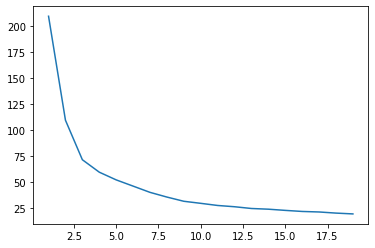

In [256]:
plt.plot(range(1,20),wcss) 
#5, vai....

In [257]:
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(insightsIhfa_Dump[['IbovCorrelation','SELICCorrelation','flowCorrelation','avgTicketCorrelation','vol']].dropna())

k_means_labels = kmeans.labels_
k_means_cluster_centers = kmeans.cluster_centers_

print("Centroids:")
print(k_means_cluster_centers)


Centroids:
[[-0.03115253 -0.68010393 -0.09704139 -0.28812077  0.07936551]
 [ 0.04172778  0.63867494 -0.03588784 -0.3546839   0.0985064 ]
 [-0.7254457   0.64084684  0.0176389  -0.29192732  0.09284521]
 [ 0.47930459 -0.77933124 -0.0543051   0.58510361  0.10879469]
 [ 0.56609586 -0.77598108  0.00876602 -0.59909958  0.12317688]]


In [258]:
transposed = pd.DataFrame(data=k_means_labels)


In [259]:
parsed = insightsIhfa_Dump.dropna().reset_index().join(transposed)
parsed = parsed.set_index("CNPJ")
parsed = parsed.rename(columns={0:"resultKmeans"})

In [274]:
lista_interpretada = firstFundFilterLayer[["CNPJ_FUNDO","DENOM_SOCIAL"]].set_index("CNPJ_FUNDO")
lista_interpretada=lista_interpretada.reset_index().rename(columns={"CNPJ_FUNDO":"CNPJ"}).set_index("CNPJ")

In [261]:
parsed.shape

(237, 6)

In [275]:
parsed2 = parsed.join(lista_interpretada)

In [276]:
parsed2.shape

(237, 7)

In [278]:
parsed2.to_csv("qualOProblema.csv")

In [266]:
parsed2.value_counts()

IbovCorrelation  SELICCorrelation  flowCorrelation  avgTicketCorrelation  vol       resultKmeans  DENOM_SOCIAL                                                                              
 0.827601        -0.840805          0.277932         0.673727             0.141085  3             GIANT ZARATHUSTRA II FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO MULTIMERCADO    1
 0.379761        -0.884191         -0.006964        -0.085428             0.122591  0             KAPITALO ZETA FUNDO DE INVESTIMENTO EM QUOTAS DE FUNDOS DE INVESTIMENTO MULTIMERCADO          1
 0.180385         0.865710          0.657301        -0.434427             0.095310  1             BB MULTIMERCADO LONGO PRAZO GLOBAL VITA PRIVATE FUNDO DE INVESTIMENTO                         1
 0.194104        -0.546346         -0.011287        -0.378022             0.091336  0             QUANTITAS FUNDO DE INVESTIMENTO MULTIMERCADO ARBITRAGEM LONGO PRAZO                           1
 0.197560         0.090001         

In [267]:
lista_interpretada.head()

,DENOM_SOCIAL
CNPJ,
26.541.175/0001-08,XP MACRO INSTITUCIONAL MASTER FUNDO DE INVESTIMENTO MULTIMERCADO
26.549.933/0001-26,XP MACRO INSTITUCIONAL FUNDO DE INVESTIMENTO EM COTAS DE FUNDO DE INVESTIMENTO MULTIMERCADO
26.605.617/0001-24,CSHG RELATIVA FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO MULTIMERCADO - CRÉD PRIV IE
26.648.868/0001-96,ALASKA BLACK FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO EM AÇÕES II - BDR NÍVEL I
26.262.556/0001-40,PORTO SAN GIORGIO MULTIMERCADO CRÉDITO PRIVADO INVESTIMENTO NO EXTERIOR FICFI


In [268]:
#pd.set_option('display.max_colwidth', None)
#pd.set_option('display.max_rows', 10)